First Lets Import Necessary Things

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil # Used for temporary cleanup if needed, but not strictly for the core logic

print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Training will run on CPU, which might be slow.")

TensorFlow Version: 2.19.0
No GPU detected. Training will run on CPU, which might be slow.

Setup complete. Ready to load data.


Load Dataset

In [27]:
# --- Define Constants and Paths ---
TRAIN_DIR = os.path.join('train')
TEST_DIR = os.path.join('test')

IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64 # Adjust based on your GPU/CPU memory
NUM_EPOCHS = 50 # Set a reasonable max, EarlyStopping will prevent overfitting
NUM_CLASSES = 7 # angry, disgust, fear, happy, neutral, sad, surprise

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Create 'models' directory if it doesn't exist to store the best model
if not os.path.exists('models'):
    os.makedirs('models')

print("\nSetup complete. Ready to load data.")


Setup complete. Ready to load data.


In [17]:
%matplotlib inline


Data Preprocessing and Data Splitting using Generators

In [28]:
# For training data: apply augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=15, # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1, # Randomly shift images horizontally
    height_shift_range=0.1, # Randomly shift images vertically
    shear_range=0.1, # Apply shear transformation
    zoom_range=0.1, # Randomly zoom into images
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest' # Fill new pixels created by transformations
)

Apply to Dataset

In [29]:
# For testing data: only normalize (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

print(f"Loading training data from: {TRAIN_DIR}")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale', # FER-2013 is grayscale
    class_mode='categorical', # For one-hot encoded labels (e.g., [0,0,1,0,0,0,0])
    shuffle=True # Shuffle data for training
)

print(f"\nLoading testing data from: {TEST_DIR}")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False # No need to shuffle test data, consistent evaluation
)

# Verify class indices mapping (important for understanding predictions)
print("\nClass Indices (mapping numerical labels to emotion names):")
print(train_generator.class_indices)

# Create a reverse mapping for easy lookup
idx_to_label = {v: k for k, v in train_generator.class_indices.items()}
print("\nReverse mapping (index to label):")
print(idx_to_label)

Loading training data from: train
Found 28709 images belonging to 7 classes.

Loading testing data from: test
Found 7178 images belonging to 7 classes.

Class Indices (mapping numerical labels to emotion names):
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

Reverse mapping (index to label):
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


Visualization (Original Image)

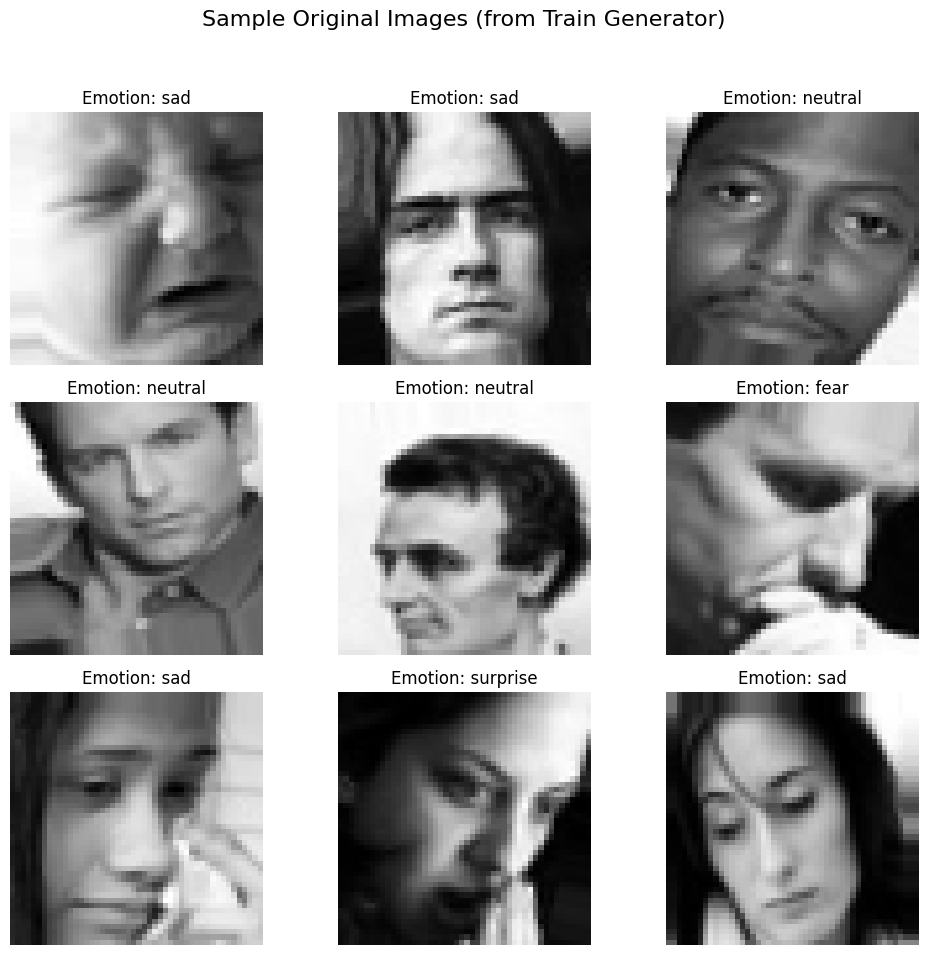

Visualization of original images complete.


In [30]:
# Get one batch of training images and labels
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
plt.suptitle("Sample Original Images (from Train Generator)", fontsize=16)

# Display up to 9 images
for i in range(min(9, len(images))):
    plt.subplot(3, 3, i + 1)
    # Remove the channel dimension (1) for grayscale image display
    plt.imshow(images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    
    # Convert one-hot encoded label back to emotion name
    predicted_label_index = np.argmax(labels[i])
    emotion_name = idx_to_label[predicted_label_index]
    
    plt.title(f"Emotion: {emotion_name}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

print("Visualization of original images complete.")

Visualization (Augmented Iamges)

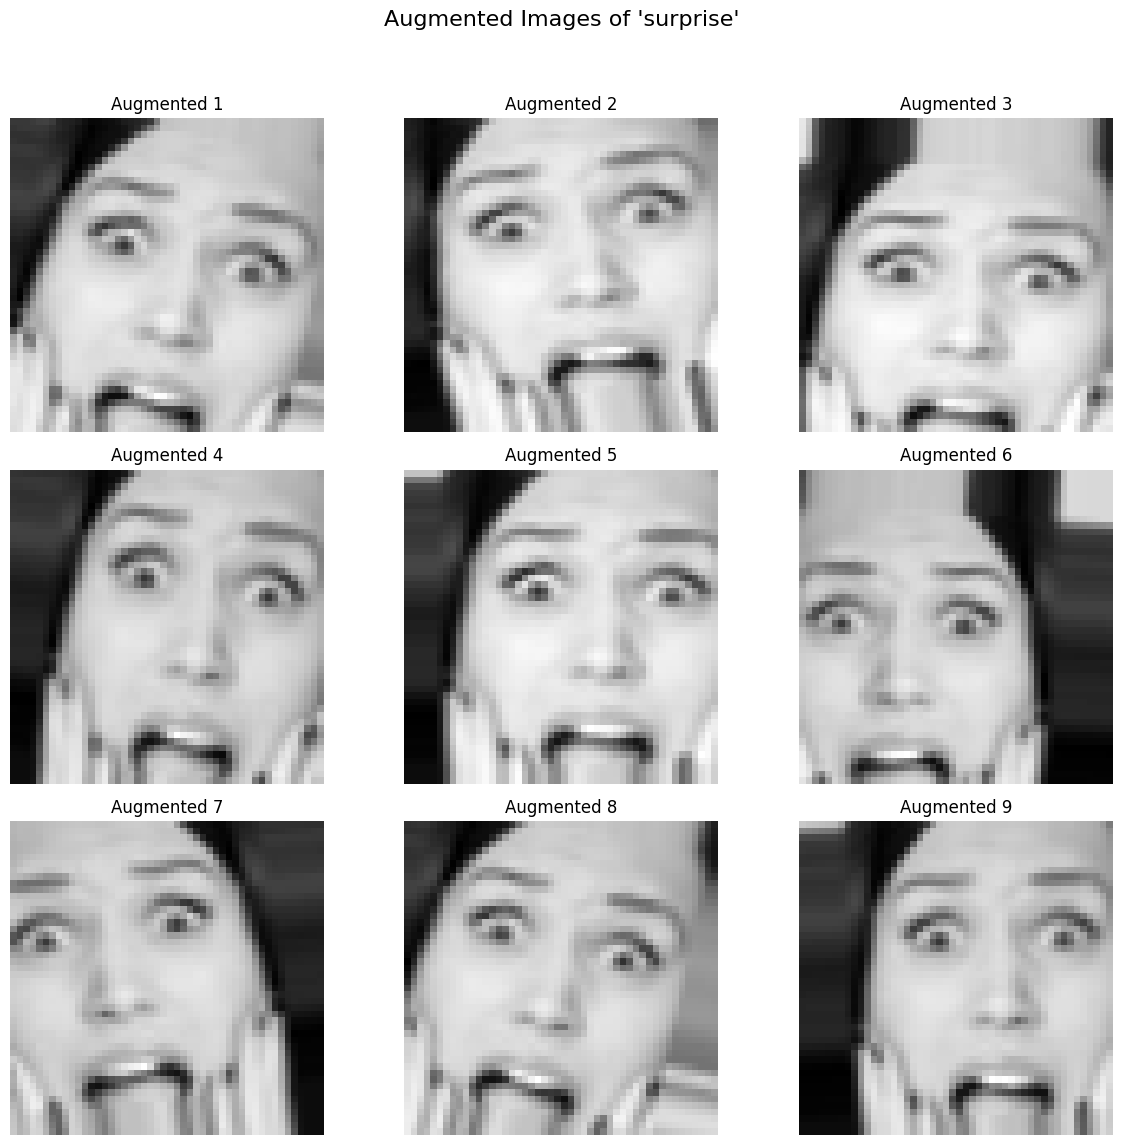

Visualization of augmented images complete.


In [31]:
# Pick a single image from the generator to demonstrate augmentation
# We'll take the first image from a batch to apply augmentation to
sample_image_batch, sample_label_batch = next(train_generator)
sample_image = sample_image_batch[0] # Take the first image
sample_label_index = np.argmax(sample_label_batch[0])
sample_emotion_name = idx_to_label[sample_label_index]

# Reshape for single image flow (add batch dimension)
sample_image_expanded = np.expand_dims(sample_image, 0)

plt.figure(figsize=(12, 12))
plt.suptitle(f"Augmented Images of '{sample_emotion_name}'", fontsize=16)

# Generate and display augmented versions of the single image
for i, batch in enumerate(train_datagen.flow(sample_image_expanded, batch_size=1)):
    if i >= 9: # Display 9 augmented versions
        break
    
    plt.subplot(3, 3, i + 1)
    # Remove the batch and channel dimensions for grayscale image display
    plt.imshow(batch[0].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Visualization of augmented images complete.")

Now Let's Build The Model

In [21]:
# Cell 5: Build the CNN Model

print("Building the CNN Model...")

model = Sequential([
    # Input Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    BatchNormalization(), # Normalizes activations of previous layer
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)), # Downsamples the feature maps, reducing spatial dimensions
    Dropout(0.25), # Randomly sets a fraction of input units to 0 to prevent overfitting

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten and Dense Layers (Classifier Head)
    Flatten(), # Flattens the 2D feature maps into a 1D vector for the fully connected layers
    Dense(256, activation='relu'), # A fully connected layer
    BatchNormalization(),
    Dropout(0.5), # Higher dropout rate for the dense layer as they are more prone to overfitting
    Dense(NUM_CLASSES, activation='softmax') # Output layer with 7 classes, softmax for probability distribution
])

# Display a summary of the model's architecture, including layer types, output shapes, and number of parameters
model.summary()

print("\nCNN Model built successfully. Summary displayed above.")

Building the CNN Model...


c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,470,951 (5.61 MB)

 Trainable params: 1,469,543 (5.61 MB)

 Non-trainable params: 1,408 (5.50 KB)


CNN Model built successfully. Summary displayed above.


Compile The Model

In [22]:
# Cell 6: Compile the Model

print("Compiling the model...")

# Define the optimizer. Adam is a good general-purpose optimizer.
# We set a learning rate to control the step size during optimization.
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', # Suitable for multi-class classification with one-hot encoded labels
              metrics=['accuracy']) # We want to track the accuracy of the model during training

print("Model compiled successfully. Ready for training!")

Compiling the model...
Model compiled successfully. Ready for training!


Define Callbacks to Avoid Overfitting and Underfitting

In [23]:
# Cell 7: Define Callbacks

print("Defining training callbacks...")

# --- 1. ModelCheckpoint ---
# Saves the model after every epoch if the 'val_accuracy' has improved.
# This ensures we keep the model that performed best on the validation set.
checkpoint_path = 'models/emotion_model_best.h5' # The path where the best model will be saved
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy', # Metric to monitor for improvement
                             verbose=1, # Show messages when checkpoint is saved
                             save_best_only=True, # Only save if the monitored metric is better than before
                             mode='max') # 'max' mode means we want to maximize 'val_accuracy'

# --- 2. EarlyStopping ---
# Stops training if the monitored metric (val_accuracy) doesn't improve for 'patience' epochs.
# This helps prevent overfitting and saves training time.
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=15, # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True) # Restore model weights from the epoch with the best value of the monitored quantity

# --- 3. ReduceLROnPlateau ---
# Reduces the learning rate when a metric (val_accuracy) has stopped improving.
# This can help the model find a better local minimum by taking smaller steps.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2, # Factor by which the learning rate will be reduced (new_lr = lr * factor)
                              patience=7, # Number of epochs with no improvement after which learning rate will be reduced
                              verbose=1,
                              min_lr=0.00001) # Lower bound on the learning rate

# Combine all callbacks into a list
callbacks_list = [checkpoint, early_stopping, reduce_lr]

print("Callbacks defined successfully. The model will be saved, early stopped, and learning rate adjusted automatically.")

Defining training callbacks...
Callbacks defined successfully. The model will be saved, early stopped, and learning rate adjusted automatically.


Now We Train The Model

In [24]:
# Cell 8: Train the Model

print("\nStarting model training...")
print(f"Training for a maximum of {NUM_EPOCHS} epochs, with EarlyStopping (patience={early_stopping.patience}) and ReduceLROnPlateau (patience={reduce_lr.patience}).")
print(f"Best model will be saved to: {checkpoint_path}")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Number of batches to draw from the training generator per epoch
    epochs=NUM_EPOCHS, # Maximum number of epochs to train for
    validation_data=test_generator, # Data on which to evaluate the loss and any model metrics at the end of each epoch
    validation_steps=test_generator.samples // BATCH_SIZE, # Number of batches to draw from the validation generator
    callbacks=callbacks_list # List of callbacks to apply during training (Checkpoint, EarlyStopping, ReduceLROnPlateau)
)

print(f"\nTraining complete. The best model, based on validation accuracy, has been saved to {checkpoint_path}.")
print("You can now proceed to evaluate the model's performance and visualize the training history.")


Starting model training...
Training for a maximum of 50 epochs, with EarlyStopping (patience=15) and ReduceLROnPlateau (patience=7).
Best model will be saved to: models/emotion_model_best.h5


c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.2254 - loss: 2.3194
Epoch 1: val_accuracy improved from -inf to 0.27888, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 288s 625ms/step - accuracy: 0.2254 - loss: 2.3188 - val_accuracy: 0.2789 - val_loss: 1.7452 - learning_rate: 0.0010
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:47 374ms/step - accuracy: 0.3281 - loss: 1.8048

c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.27888 to 0.29171, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3281 - loss: 1.8048 - val_accuracy: 0.2917 - val_loss: 1.7171 - learning_rate: 0.0010
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.3562 - loss: 1.6674
Epoch 3: val_accuracy improved from 0.29171 to 0.47628, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 206s 459ms/step - accuracy: 0.3562 - loss: 1.6672 - val_accuracy: 0.4763 - val_loss: 1.3661 - learning_rate: 0.0010
Epoch 4/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:16 708ms/step - accuracy: 0.4688 - loss: 1.4236
Epoch 4: val_accuracy did not improve from 0.47628
448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.4688 - loss: 1.4236 - val_accuracy: 0.4747 - val_loss: 1.3666 - learning_rate: 0.0010
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.4460 - loss: 1.4357
Epoch 5: val_accuracy did not improve from 0.47628
448/448 ━━━━━━━━━━━━━━━━━━━━ 190s 424ms/step - accuracy: 0.4461 - loss: 1.4357 - val_accuracy: 0.3361 - val_loss: 1.9926 - learning_rate: 0.0010
Epoch 6/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:43 367ms/step - accuracy: 0.5469 - loss: 1.2140
Epoch 6: val_accuracy did not improve from 0.47628
448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5469 - loss: 1.2140 - val_accuracy: 0.3297 - val_loss: 2.0193 - learning_rate: 0.0010
Epo

448/448 ━━━━━━━━━━━━━━━━━━━━ 208s 465ms/step - accuracy: 0.4833 - loss: 1.3520 - val_accuracy: 0.4888 - val_loss: 1.3580 - learning_rate: 0.0010
Epoch 8/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:05 415ms/step - accuracy: 0.5156 - loss: 1.2971
Epoch 8: val_accuracy improved from 0.48884 to 0.49219, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5156 - loss: 1.2971 - val_accuracy: 0.4922 - val_loss: 1.3454 - learning_rate: 0.0010
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.5162 - loss: 1.2826
Epoch 9: val_accuracy improved from 0.49219 to 0.54925, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 194s 432ms/step - accuracy: 0.5162 - loss: 1.2826 - val_accuracy: 0.5492 - val_loss: 1.1803 - learning_rate: 0.0010
Epoch 10/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:44 368ms/step - accuracy: 0.6094 - loss: 1.1516
Epoch 10: val_accuracy improved from 0.54925 to 0.55036, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6094 - loss: 1.1516 - val_accuracy: 0.5504 - val_loss: 1.1776 - learning_rate: 0.0010
Epoch 11/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5188 - loss: 1.2586
Epoch 11: val_accuracy did not improve from 0.55036
448/448 ━━━━━━━━━━━━━━━━━━━━ 186s 415ms/step - accuracy: 0.5188 - loss: 1.2585 - val_accuracy: 0.5179 - val_loss: 1.2812 - learning_rate: 0.0010
Epoch 12/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:48 377ms/step - accuracy: 0.4375 - loss: 1.3561
Epoch 12: val_accuracy did not improve from 0.55036
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4375 - loss: 1.3561 - val_accuracy: 0.5282 - val_loss: 1.2460 - learning_rate: 0.0010
Epoch 13/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5377 - loss: 1.2153
Epoch 13: val_accuracy improved from 0.55036 to 0.57031, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 180s 402ms/step - accuracy: 0.5377 - loss: 1.2153 - val_accuracy: 0.5703 - val_loss: 1.1359 - learning_rate: 0.0010
Epoch 14/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:46 372ms/step - accuracy: 0.4531 - loss: 1.5066
Epoch 14: val_accuracy improved from 0.57031 to 0.57143, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4531 - loss: 1.5066 - val_accuracy: 0.5714 - val_loss: 1.1433 - learning_rate: 0.0010
Epoch 15/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.5493 - loss: 1.1863
Epoch 15: val_accuracy did not improve from 0.57143
448/448 ━━━━━━━━━━━━━━━━━━━━ 183s 408ms/step - accuracy: 0.5493 - loss: 1.1863 - val_accuracy: 0.5693 - val_loss: 1.1270 - learning_rate: 0.0010
Epoch 16/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:41 362ms/step - accuracy: 0.5469 - loss: 1.3645
Epoch 16: val_accuracy improved from 0.57143 to 0.57268, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5469 - loss: 1.3645 - val_accuracy: 0.5727 - val_loss: 1.1181 - learning_rate: 0.0010
Epoch 17/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5595 - loss: 1.1597
Epoch 17: val_accuracy did not improve from 0.57268
448/448 ━━━━━━━━━━━━━━━━━━━━ 185s 413ms/step - accuracy: 0.5595 - loss: 1.1597 - val_accuracy: 0.5455 - val_loss: 1.2676 - learning_rate: 0.0010
Epoch 18/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:41 361ms/step - accuracy: 0.5312 - loss: 1.2628
Epoch 18: val_accuracy did not improve from 0.57268
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5312 - loss: 1.2628 - val_accuracy: 0.5483 - val_loss: 1.2560 - learning_rate: 0.0010
Epoch 19/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.5688 - loss: 1.1381
Epoch 19: val_accuracy improved from 0.57268 to 0.59780, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 190s 424ms/step - accuracy: 0.5688 - loss: 1.1382 - val_accuracy: 0.5978 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 20/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:45 369ms/step - accuracy: 0.5938 - loss: 1.1375
Epoch 20: val_accuracy did not improve from 0.59780
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5938 - loss: 1.1375 - val_accuracy: 0.5956 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 21/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5655 - loss: 1.1423
Epoch 21: val_accuracy improved from 0.59780 to 0.60003, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 182s 405ms/step - accuracy: 0.5655 - loss: 1.1422 - val_accuracy: 0.6000 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 22/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:39 358ms/step - accuracy: 0.6562 - loss: 0.8970
Epoch 22: val_accuracy improved from 0.60003 to 0.60031, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6562 - loss: 0.8970 - val_accuracy: 0.6003 - val_loss: 1.0617 - learning_rate: 0.0010
Epoch 23/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.5898 - loss: 1.0967
Epoch 23: val_accuracy improved from 0.60031 to 0.60463, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 197s 441ms/step - accuracy: 0.5898 - loss: 1.0968 - val_accuracy: 0.6046 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 24/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:02 408ms/step - accuracy: 0.5781 - loss: 1.1876
Epoch 24: val_accuracy improved from 0.60463 to 0.60589, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5781 - loss: 1.1876 - val_accuracy: 0.6059 - val_loss: 1.0422 - learning_rate: 0.0010
Epoch 25/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5898 - loss: 1.0952
Epoch 25: val_accuracy did not improve from 0.60589
448/448 ━━━━━━━━━━━━━━━━━━━━ 190s 425ms/step - accuracy: 0.5898 - loss: 1.0952 - val_accuracy: 0.5682 - val_loss: 1.1454 - learning_rate: 0.0010
Epoch 26/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:48 377ms/step - accuracy: 0.6250 - loss: 1.0164
Epoch 26: val_accuracy did not improve from 0.60589
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6250 - loss: 1.0164 - val_accuracy: 0.5660 - val_loss: 1.1499 - learning_rate: 0.0010
Epoch 27/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5945 - loss: 1.0724
Epoch 27: val_accuracy improved from 0.60589 to 0.60840, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 184s 412ms/step - accuracy: 0.5945 - loss: 1.0724 - val_accuracy: 0.6084 - val_loss: 1.0442 - learning_rate: 0.0010
Epoch 28/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:40 358ms/step - accuracy: 0.6094 - loss: 1.0176
Epoch 28: val_accuracy did not improve from 0.60840
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6094 - loss: 1.0176 - val_accuracy: 0.6074 - val_loss: 1.0458 - learning_rate: 0.0010
Epoch 29/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5898 - loss: 1.0758
Epoch 29: val_accuracy improved from 0.60840 to 0.61537, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 198s 443ms/step - accuracy: 0.5898 - loss: 1.0758 - val_accuracy: 0.6154 - val_loss: 1.0230 - learning_rate: 0.0010
Epoch 30/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:38 354ms/step - accuracy: 0.6094 - loss: 0.9198
Epoch 30: val_accuracy did not improve from 0.61537
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6094 - loss: 0.9198 - val_accuracy: 0.6144 - val_loss: 1.0251 - learning_rate: 0.0010
Epoch 31/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5995 - loss: 1.0641
Epoch 31: val_accuracy did not improve from 0.61537
448/448 ━━━━━━━━━━━━━━━━━━━━ 183s 409ms/step - accuracy: 0.5995 - loss: 1.0641 - val_accuracy: 0.5935 - val_loss: 1.0998 - learning_rate: 0.0010
Epoch 32/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:44 367ms/step - accuracy: 0.5938 - loss: 0.9752
Epoch 32: val_accuracy did not improve from 0.61537
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5938 - loss: 0.9752 - val_accuracy: 0.5960 - val_loss: 1.0930 - learning_rate: 0.0010

448/448 ━━━━━━━━━━━━━━━━━━━━ 232s 518ms/step - accuracy: 0.6248 - loss: 1.0050 - val_accuracy: 0.6299 - val_loss: 0.9779 - learning_rate: 2.0000e-04
Epoch 38/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:44 367ms/step - accuracy: 0.5781 - loss: 1.1921
Epoch 38: val_accuracy improved from 0.62988 to 0.63058, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5781 - loss: 1.1921 - val_accuracy: 0.6306 - val_loss: 0.9778 - learning_rate: 2.0000e-04
Epoch 39/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6355 - loss: 0.9800
Epoch 39: val_accuracy improved from 0.63058 to 0.63923, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 202s 451ms/step - accuracy: 0.6355 - loss: 0.9800 - val_accuracy: 0.6392 - val_loss: 0.9651 - learning_rate: 2.0000e-04
Epoch 40/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:42 364ms/step - accuracy: 0.7500 - loss: 0.7340
Epoch 40: val_accuracy did not improve from 0.63923
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.7500 - loss: 0.7340 - val_accuracy: 0.6388 - val_loss: 0.9657 - learning_rate: 2.0000e-04
Epoch 41/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6341 - loss: 0.9748
Epoch 41: val_accuracy did not improve from 0.63923
448/448 ━━━━━━━━━━━━━━━━━━━━ 222s 494ms/step - accuracy: 0.6341 - loss: 0.9748 - val_accuracy: 0.6309 - val_loss: 0.9740 - learning_rate: 2.0000e-04
Epoch 42/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:49 378ms/step - accuracy: 0.6875 - loss: 0.8144
Epoch 42: val_accuracy did not improve from 0.63923
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6875 - loss: 0.8144 - val_accuracy: 0.6317 - val_loss: 0.9746 - learning

448/448 ━━━━━━━━━━━━━━━━━━━━ 202s 451ms/step - accuracy: 0.6431 - loss: 0.9629 - val_accuracy: 0.6443 - val_loss: 0.9596 - learning_rate: 2.0000e-04
Epoch 44/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:07 420ms/step - accuracy: 0.6406 - loss: 0.9533
Epoch 44: val_accuracy did not improve from 0.64425
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.6406 - loss: 0.9533 - val_accuracy: 0.6440 - val_loss: 0.9593 - learning_rate: 2.0000e-04
Epoch 45/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6403 - loss: 0.9647
Epoch 45: val_accuracy did not improve from 0.64425
448/448 ━━━━━━━━━━━━━━━━━━━━ 205s 458ms/step - accuracy: 0.6403 - loss: 0.9647 - val_accuracy: 0.6412 - val_loss: 0.9598 - learning_rate: 2.0000e-04
Epoch 46/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:11 427ms/step - accuracy: 0.5938 - loss: 1.1323
Epoch 46: val_accuracy did not improve from 0.64425
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5938 - loss: 1.1323 - val_accuracy: 0.6399 - val_loss: 0.9609 - learnin

448/448 ━━━━━━━━━━━━━━━━━━━━ 255s 569ms/step - accuracy: 0.6456 - loss: 0.9494 - val_accuracy: 0.6466 - val_loss: 0.9473 - learning_rate: 2.0000e-04
Epoch 50/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:58 400ms/step - accuracy: 0.6719 - loss: 0.8287
Epoch 50: val_accuracy improved from 0.64662 to 0.64760, saving model to models/emotion_model_best.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6719 - loss: 0.8287 - val_accuracy: 0.6476 - val_loss: 0.9463 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 50.

Training complete. The best model, based on validation accuracy, has been saved to models/emotion_model_best.h5.
You can now proceed to evaluate the model's performance and visualize the training history.


Model Performance Visualization


--- Model Evaluation and History Visualization ---

Ensuring test_generator and validation_steps are ready...
test_generator found in memory.
validation_steps not found in memory. Recalculating...
validation_steps recalculated: 113

Loading the best model for final evaluation...


Successfully loaded best model from models/emotion_model_best.h5

Evaluating the best model on the test set...
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.5978 - loss: 1.0373

Final Best Model Test Loss: 0.9451
Final Best Model Test Accuracy: 0.6481

Plotting training history (Accuracy and Loss over Epochs)...


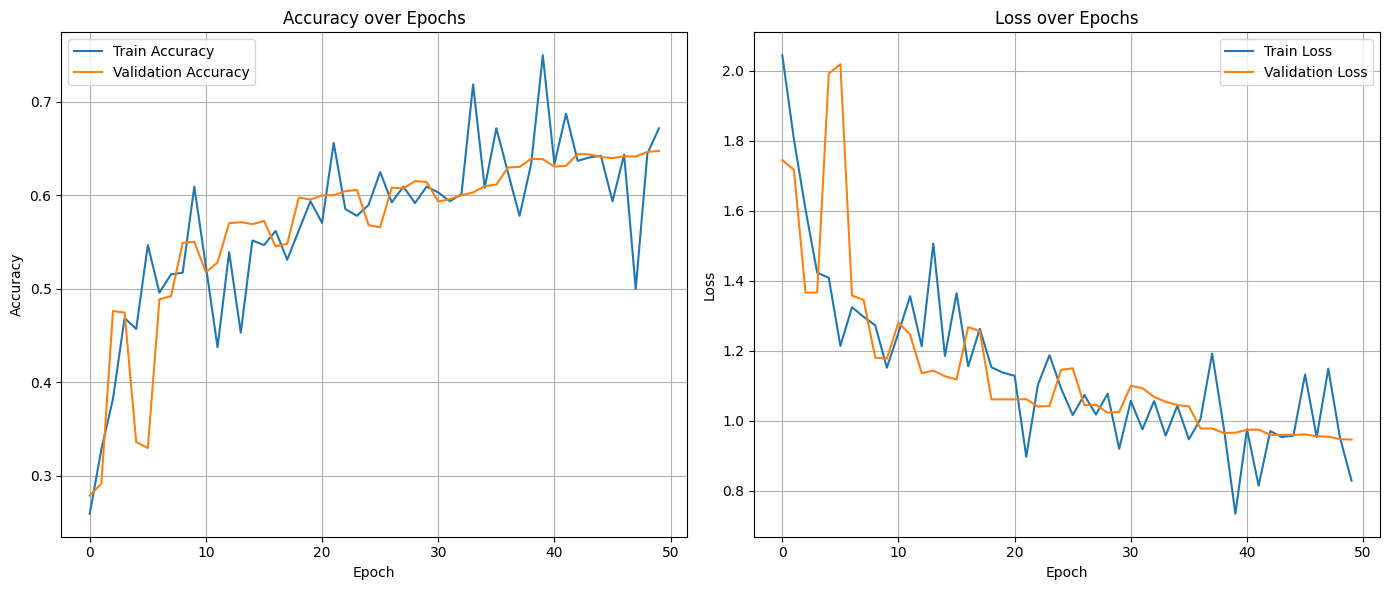


Training history visualization complete. Review messages above for any skipped sections.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import math # Needed for ceil

print("\n--- Model Evaluation and History Visualization ---")

DATASET_PATH = 'FER-2013'
TEST_DIR = os.path.join(DATASET_PATH, 'test')
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
NUM_CLASSES = 7
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

checkpoint_path = 'models/emotion_model_best.h5'

print("\nEnsuring test_generator and validation_steps are ready...")

# Check if test_generator is in the current session's memory
if 'test_generator' not in locals():
    print("test_generator not found in memory. Attempting to recreate it...")
    from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import again if needed
    test_datagen = ImageDataGenerator(rescale=1./255) # Only normalization for test
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=False
    )
    print("test_generator recreated.")
else:
    print("test_generator found in memory.")

# Check if validation_steps is in the current session's memory
if 'validation_steps' not in locals():
    print("validation_steps not found in memory. Recalculating...")
    validation_steps = math.ceil(test_generator.samples / BATCH_SIZE)
    print(f"validation_steps recalculated: {validation_steps}")
else:
    print("validation_steps found in memory.")

# Re-create idx_to_label if needed for plotting (depends on train_generator being available, or just use emotion_labels)
if 'idx_to_label' not in locals() and 'train_generator' in locals():
    print("idx_to_label not found, trying to recreate from train_generator...")
    idx_to_label = {v: k for k, v in train_generator.class_indices.items()}
elif 'idx_to_label' not in locals():
    print("idx_to_label not found and train_generator is not available. Using emotion_labels for general reference.")
    idx_to_label = {i: label for i, label in enumerate(emotion_labels)} # Fallback for display

# --- 2. Load the Best Model for Final Evaluation ---
print("\nLoading the best model for final evaluation...")
try:
    best_model = tf.keras.models.load_model(checkpoint_path)
    print(f"Successfully loaded best model from {checkpoint_path}")
except Exception as e:
    print(f"Error loading best model from {checkpoint_path}: {e}")
    print("Please ensure the model file exists at the specified path and is not corrupted.")
    # If the model can't be loaded, we can't proceed with evaluation
    best_model = None # Set to None to skip evaluation

if best_model:
    print("\nEvaluating the best model on the test set...")
    # Ensure test_generator and validation_steps are now defined
    if 'test_generator' in locals() and 'validation_steps' in locals():
        loss, accuracy = best_model.evaluate(test_generator, steps=validation_steps, verbose=1)
        print(f"\nFinal Best Model Test Loss: {loss:.4f}")
        print(f"Final Best Model Test Accuracy: {accuracy:.4f}")
    else:
        print("Cannot perform evaluation: test_generator or validation_steps are still missing.")
else:
    print("Skipping evaluation as the model could not be loaded.")


#  Plotting Training History
print("\nPlotting training history (Accuracy and Loss over Epochs)...")

# Check if 'history' object is still in memory. If the kernel was restarted, it likely won't be.
if 'history' not in locals():
    print("Warning: 'history' object not found in memory.")
    print("This means the training process (Cell 8) was not run in this session or the kernel was restarted after it completed.")
    print("Training plots (accuracy/loss curves) cannot be generated without the 'history' object.")
    print("Tip: In future projects, you can save `history.history` (which is a dictionary) to a JSON or pickle file after training, then load it to plot later.")
else:
    plt.figure(figsize=(14, 6))

    # Subplot 1: Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("\nTraining history visualization complete. Review messages above for any skipped sections.")